# ML Pipeline

In [1]:
import geoengine as ge
from geoengine.ml import MlModelConfig

from geoengine_openapi_client.models import MlModelMetadata, RasterDataType, TensorShape3D

from sklearn.tree import DecisionTreeClassifier
import numpy as np
from skl2onnx import to_onnx


In [2]:
ge.initialize("http://localhost:3030/api")

## Train a dummy model (TODO: feed with data from Geo Engine)

In [3]:
np.random.seed(0) 
X = np.random.rand(100, 2).astype(np.float32)  # 100 instances, 2 features
y = np.where(X[:, 0] > X[:, 1], 42, 33)  # 1 if feature 0 > feature 42, else 33

clf = DecisionTreeClassifier()
clf.fit(X, y)

test_samples = np.array([[0.1, 0.2], [0.2, 0.1]])
predictions = clf.predict(test_samples)
print("Predictions:", predictions)

# Convert into ONNX format.
onx = to_onnx(clf, X[:1], options={"zipmap": False}, target_opset=9) # target_opset is the ONNX version to use

Predictions: [33 42]


## Register it with Geo Engine

In [4]:


model_name = f"{ge.get_session().user_id}:decision_tree"

metadata = MlModelMetadata(
    file_name="model.onnx",
    input_type=RasterDataType.F32,
    output_type=RasterDataType.I64,
    input_shape=TensorShape3D(y=1, x=1, bands=2),
    output_shape=TensorShape3D(y=1, x=1, bands=1)
)

model_config = MlModelConfig(
    name=model_name,
    metadata=metadata,
    display_name="Decision Tree",
    description="A simple decision tree model",
)

ge.register_ml_model(onnx_model=onx, model_config=model_config)

## Apply model using the ONNX operator

The image shows rise and fall in ndvi in 2014-04 with respect to the previous month.

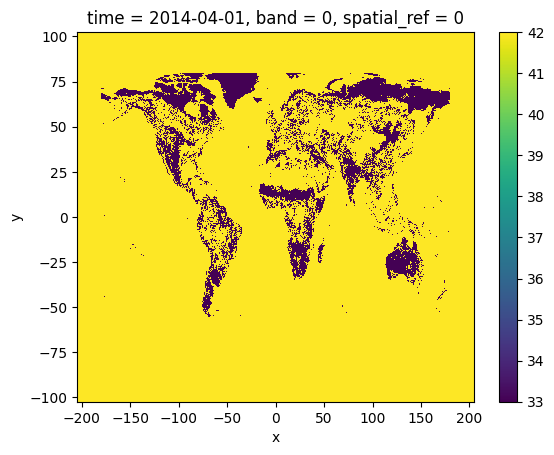

In [5]:
# create raster with two bands, one ndvi of current month and one ndvi of the previous month
bands = [ge.workflow_builder.operators.GdalSource("ndvi"),
         ge.workflow_builder.operators.TimeShift(source=ge.workflow_builder.operators.GdalSource("ndvi"), 
                                                 shift_type="relative", 
                                                 granularity="months", 
                                                 value=-1)]
stack = ge.workflow_builder.operators.RasterStacker(sources = bands)

# normalize the input to 0-1 and convert to float32
normalized = ge.workflow_builder.operators.BandwiseExpression(expression="x/255", source=stack, output_type="F32")

# use the registered ml model for prediction
onnx = ge.workflow_builder.operators.Onnx(source=normalized, model=model_name)

# convert the predictions to U8 because ONNX outputs I64 which our Gdal version output currently
converted_output = ge.workflow_builder.operators.RasterTypeConversion(source=onnx, output_data_type="U8")

workflow_dict = converted_output.to_workflow_dict()

workflow = ge.register_workflow(workflow_dict)

query = ge.QueryRectangle(
    ge.BoundingBox2D(-180, -90, 180, 90),
    ge.TimeInterval(np.datetime64('2014-04-01')),
    ge.SpatialResolution(0.1, 0.1)
)

data = await workflow.raster_stream_into_xarray(
    query
)

data.plot();